With 79 explanatory variables describing (almost) every aspect of residential homes in Ames, Iowa, this project challenges to predict the final price of each home.

In [641]:
import os
import warnings
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)
import statsmodels.api as sm
from scipy import stats
from scipy.stats import norm
from sklearn.model_selection import train_test_split

import sklearn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import scale
from sklearn.feature_selection import RFE
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import make_pipeline
from tqdm.notebook import tqdm, trange
import time 

from sklearn.linear_model import Ridge
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline
from sklearn import preprocessing
from sklearn import model_selection

In [234]:
train=pd.read_csv('train.csv')
test=pd.read_csv('test.csv')

In [222]:
train.head(5)

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [34]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   Alley          91 non-null     object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-null   object 
 14  Condition2     1460 non-null   object 
 15  BldgType       1460 non-null   object 
 16  HouseStyle     1460 non-null   object 
 17  OverallQual    1460 non-null   int64  
 18  OverallC

In [38]:
train['YrSold'].value_counts(ascending=False).sort_values(ascending=False)

2009    338
2007    329
2006    314
2008    304
2010    175
Name: YrSold, dtype: int64

In [111]:
def details(data,target):
    shape= data.shape
    d=data.shape[0]
    types=data.dtypes
    counts= data.apply(lambda x: x.count())
    nulls = data.apply(lambda x: x.isnull().sum())
    distincts = data.apply(lambda x: x.unique().shape[0])
    missing_ration = (data.isnull().sum()/d) * 100
    skewness = train.skew()
    kurtosis = train.kurt() 
    print('Data shape:', shape)
    if target is None:
        cols = ['types', 'counts', 'distincts', 'nulls', 'missing ration','skewness', 'kurtosis']
        str = pd.concat([types, counts, distincts, nulls, missing_ration,skewness, kurtosis], axis = 1)
    else:
        corr = data.corr(method='pearson')[target]
        str = pd.concat([types, counts, distincts, nulls, missing_ration,skewness, kurtosis,corr], axis = 1)
        cols = ['types', 'counts', 'distincts', 'nulls', 'missing ration','skewness', 'kurtosis','corrSalePrice']
        str.columns = cols
        dtypes = str.types.value_counts()
        print('___________________________\nData types:\n',str.types.value_counts())
        print('___________________________')
        return str

In [112]:
details=details(train, 'SalePrice')

Data shape: (1460, 81)
___________________________
Data types:
 object     43
int64      35
float64     3
Name: types, dtype: int64
___________________________


In [113]:
details

,types,counts,distincts,nulls,missing ration,skewness,kurtosis,corrSalePrice
Id,int64,1460,1460,0,0.000000,0.000000,-1.200000,-0.021917
MSSubClass,int64,1460,15,0,0.000000,1.407657,1.580188,-0.084284
MSZoning,object,1460,5,0,0.000000,NaN,NaN,NaN
LotFrontage,float64,1201,111,259,17.739726,2.163569,17.452867,0.351799
LotArea,int64,1460,1073,0,0.000000,12.207688,203.243271,0.263843
...,...,...,...,...,...,...,...,...
MoSold,int64,1460,12,0,0.000000,0.212053,-0.404109,0.046432
YrSold,int64,1460,5,0,0.000000,0.096269,-1.190601,-0.028923
SaleType,object,1460,9,0,0.000000,NaN,NaN,NaN
SaleCondition,object,1460,6,0,0.000000,NaN,NaN,NaN


# Some notes:

# 1. Missing values

In [114]:
variables_with_nulls=details.loc[details['nulls'] !=0]
variables_with_nulls

,types,counts,distincts,nulls,missing ration,skewness,kurtosis,corrSalePrice
LotFrontage,float64,1201,111,259,17.739726,2.163569,17.452867,0.351799
Alley,object,91,3,1369,93.767123,NaN,NaN,NaN
MasVnrType,object,1452,5,8,0.547945,NaN,NaN,NaN
MasVnrArea,float64,1452,328,8,0.547945,2.669084,10.082417,0.477493
BsmtQual,object,1423,5,37,2.534247,NaN,NaN,NaN
BsmtCond,object,1423,5,37,2.534247,NaN,NaN,NaN
BsmtExposure,object,1422,5,38,2.602740,NaN,NaN,NaN
BsmtFinType1,object,1423,7,37,2.534247,NaN,NaN,NaN
BsmtFinType2,object,1422,7,38,2.602740,NaN,NaN,NaN
Electrical,object,1459,6,1,0.068493,NaN,NaN,NaN


In [115]:
variables_with_nulls.shape

(19, 8)

# 19 features with nulls

We can see that some features have missing rate more than 47%, so a lot of values are missing. They are candidates to drop. This features are: Fence, MiscFeature, PoolQC, fireplaceQC, Alley.

# 2. Correlation

In [116]:
details.sort_values(by='corrSalePrice', ascending=False)

,types,counts,distincts,nulls,missing ration,skewness,kurtosis,corrSalePrice
SalePrice,int64,1460,663,0,0.000000,1.882876,6.536282,1.000000
OverallQual,int64,1460,10,0,0.000000,0.216944,0.096293,0.790982
GrLivArea,int64,1460,861,0,0.000000,1.366560,4.895121,0.708624
GarageCars,int64,1460,5,0,0.000000,-0.342549,0.220998,0.640409
GarageArea,int64,1460,441,0,0.000000,0.179981,0.917067,0.623431
...,...,...,...,...,...,...,...,...
PoolQC,object,7,4,1453,99.520548,NaN,NaN,NaN
Fence,object,281,5,1179,80.753425,NaN,NaN,NaN
MiscFeature,object,54,5,1406,96.301370,NaN,NaN,NaN
SaleType,object,1460,9,0,0.000000,NaN,NaN,NaN


# Big corralation

In [148]:
details.loc[(details['corrSalePrice'] >= 0.6) | (details['corrSalePrice'] <= -0.6) ] #high corralation

,types,counts,distincts,nulls,missing ration,skewness,kurtosis,corrSalePrice
OverallQual,int64,1460,10,0,0.0,0.216944,0.096293,0.790982
TotalBsmtSF,int64,1460,721,0,0.0,1.524255,13.250483,0.613581
1stFlrSF,int64,1460,753,0,0.0,1.376757,5.745841,0.605852
GrLivArea,int64,1460,861,0,0.0,1.366560,4.895121,0.708624
GarageCars,int64,1460,5,0,0.0,-0.342549,0.220998,0.640409
GarageArea,int64,1460,441,0,0.0,0.179981,0.917067,0.623431
SalePrice,int64,1460,663,0,0.0,1.882876,6.536282,1.000000


We notice that Overall Quallity has the biggest corralation with sale price. This is expected! This variable rates the overall material and finish of the house, with grades from 10(excellent) to 1(very poor). Also GrLivArea, GarafeCars, GarageArea are the next 3 variables with big corralation. We can check some details between Overall quality and Sale price. And also between the other 3 variables.

# Overall Quallity, GrLivArea, GarafeCars, GarageArea have biggest corralation

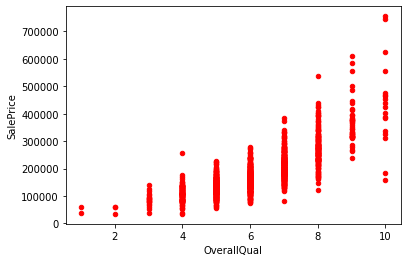

In [142]:
train.plot(kind='scatter',x='OverallQual',y='SalePrice',color='red')
plt.show()

We see big big corralation between sale Price and OverallQual indeed. Let's check all variables with big corralation:

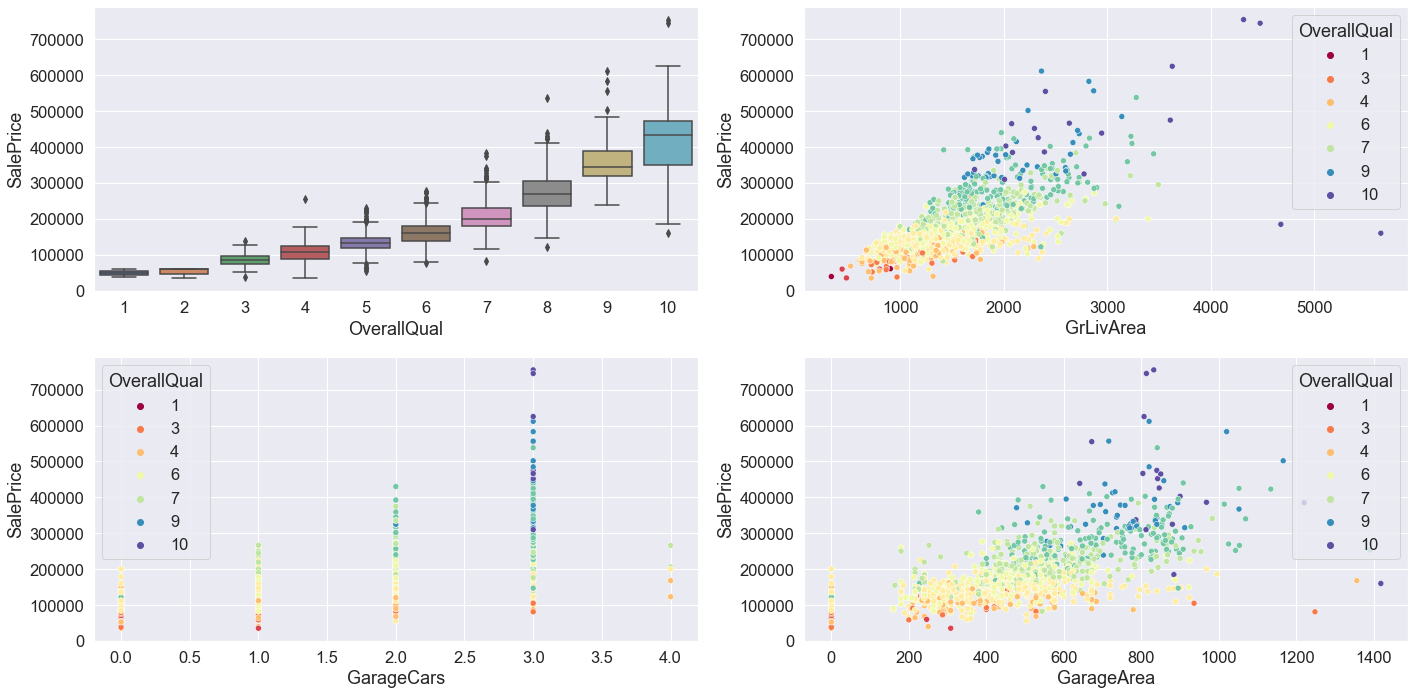

In [175]:
fig = plt.figure(figsize=(20, 10))
sns.set(font_scale=1.5)

#Overallqual vs salePrice/boxplot
fig1 = fig.add_subplot(221);
sns.boxplot(x='OverallQual', y='SalePrice', data=train)

# GrLivArea vs SalePrice/Scatterplot
fig2 = fig.add_subplot(222); 
sns.scatterplot(x='GrLivArea', y='SalePrice', hue='OverallQual', data=train, palette= 'Spectral')

#GarageCars vs SalePrice/ Scatterplot
fig3 = fig.add_subplot(223); 
sns.scatterplot(x = 'GarageCars', y = 'SalePrice', hue='OverallQual',data=train, palette= 'Spectral')

#GarageArea vs SalePrice /Scatterplot
fig4 = fig.add_subplot(224); 
sns.scatterplot(x = 'GarageArea', y = 'SalePrice', hue='OverallQual',data=train, palette= 'Spectral')


plt.tight_layout(); plt.show()

# low corralation

In [134]:
details.loc[(details['corrSalePrice'] >=-0.2) & (details['corrSalePrice'] <= 0.2)] #low corralation

,types,counts,distincts,nulls,missing ration,skewness,kurtosis,corrSalePrice
Id,int64,1460,1460,0,0.0,0.000000,-1.200000,-0.021917
MSSubClass,int64,1460,15,0,0.0,1.407657,1.580188,-0.084284
OverallCond,int64,1460,9,0,0.0,0.693067,1.106413,-0.077856
BsmtFinSF2,int64,1460,144,0,0.0,4.255261,20.113338,-0.011378
LowQualFinSF,int64,1460,24,0,0.0,9.011341,83.234817,-0.025606
BsmtHalfBath,int64,1460,3,0,0.0,4.103403,16.396642,-0.016844
BedroomAbvGr,int64,1460,8,0,0.0,0.211790,2.230875,0.168213
KitchenAbvGr,int64,1460,4,0,0.0,4.488397,21.532404,-0.135907
EnclosedPorch,int64,1460,120,0,0.0,3.089872,10.430766,-0.128578
3SsnPorch,int64,1460,20,0,0.0,10.304342,123.662379,0.044584


For example BsmtFinSF2 is a numerical variable. It shows Type 2 finished square feet and has low corralation with Sale Price. Let's see it:

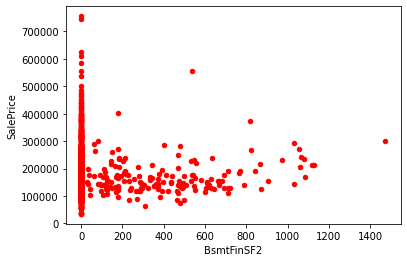

In [144]:
train.plot(kind='scatter',x='BsmtFinSF2',y='SalePrice',color='red')
plt.show()

In [103]:
details['corrSalePrice'].value_counts().shape

(38,)

In [145]:
train.describe().transpose() #main statistics of our numeric data

,count,mean,std,min,25%,50%,75%,max
Id,1460.0,730.500000,421.610009,1.0,365.75,730.5,1095.25,1460.0
MSSubClass,1460.0,56.897260,42.300571,20.0,20.00,50.0,70.00,190.0
LotFrontage,1201.0,70.049958,24.284752,21.0,59.00,69.0,80.00,313.0
LotArea,1460.0,10516.828082,9981.264932,1300.0,7553.50,9478.5,11601.50,215245.0
OverallQual,1460.0,6.099315,1.382997,1.0,5.00,6.0,7.00,10.0
OverallCond,1460.0,5.575342,1.112799,1.0,5.00,5.0,6.00,9.0
YearBuilt,1460.0,1971.267808,30.202904,1872.0,1954.00,1973.0,2000.00,2010.0
YearRemodAdd,1460.0,1984.865753,20.645407,1950.0,1967.00,1994.0,2004.00,2010.0
MasVnrArea,1452.0,103.685262,181.066207,0.0,0.00,0.0,166.00,1600.0
BsmtFinSF1,1460.0,443.639726,456.098091,0.0,0.00,383.5,712.25,5644.0


# Delete outliers

In [223]:
train.shape

(1460, 81)

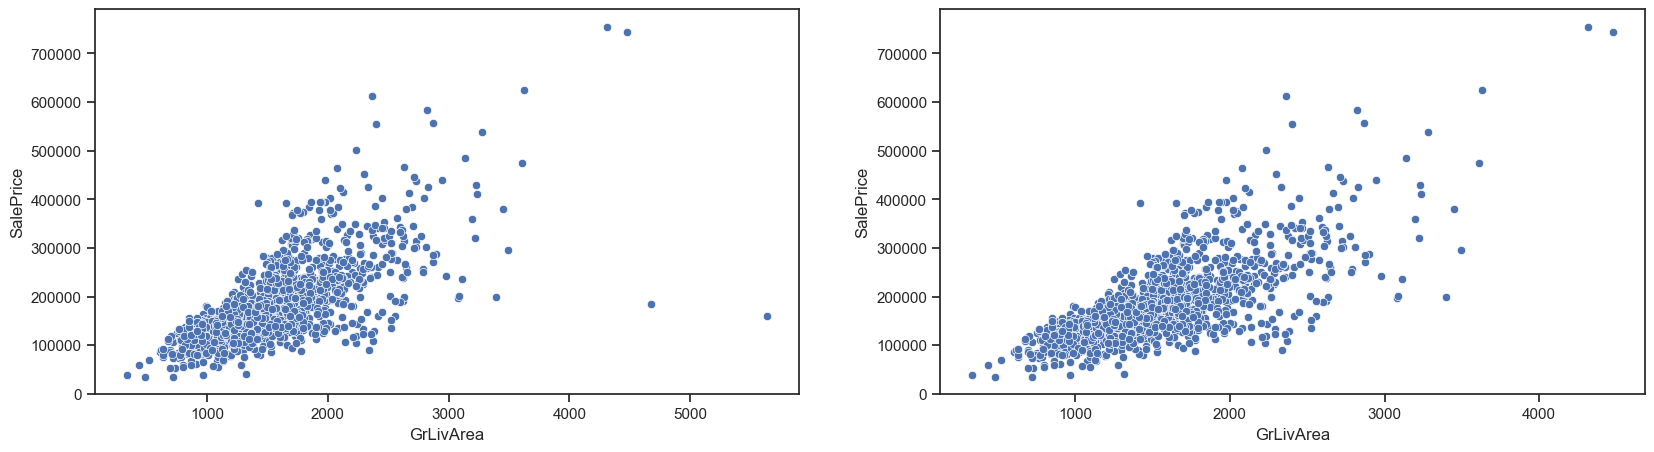

In [235]:
fig = plt.figure(figsize=(20,5))
ax = fig.add_subplot(121)
sns.scatterplot(x='GrLivArea', y='SalePrice', ax = ax, data=train)

#Deleting outliers
train = train.drop(train[(train.GrLivArea>4000) & (train.SalePrice<300000)].index)

#Check the graphic again
ax = fig.add_subplot(122)
sns.scatterplot(x ='GrLivArea', y = 'SalePrice', ax = ax, data=train)
plt.show()

In [236]:
train.shape

(1458, 81)

# Explore all data - check if we can do feature selection for improving the regression

Total Rooms above grade(does not incude bathrooms ) is variable TotRmsAbvGrd and Above grade (ground) living area square feet is variable GrLivArea, we expect a big corralation between them and we may can combine them to one variable. Let's see what will happen if we combine the two variables

C:\Users\Christina\anaconda3\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
C:\Users\Christina\anaconda3\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


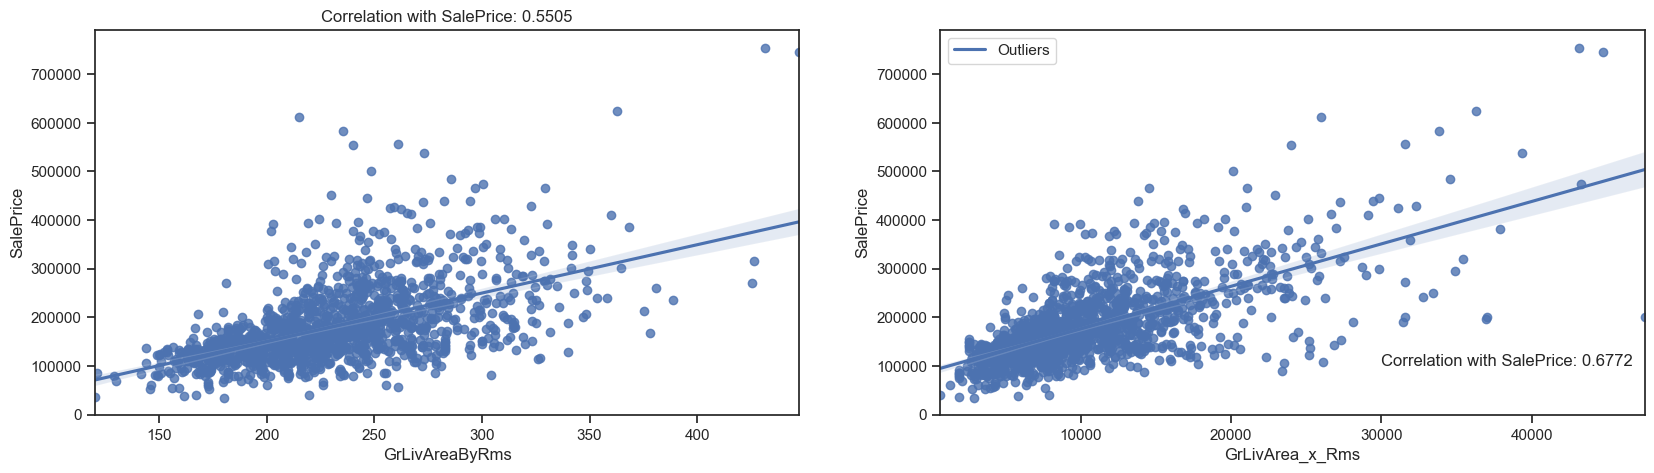

In [240]:
sns.reset_defaults()
sns.set(style="ticks", color_codes=True)
df = train[['SalePrice', 'GrLivArea', 'TotRmsAbvGrd']]

df['GrLivAreaByRms']=train[ 'GrLivArea']/train['TotRmsAbvGrd']
df['GrLivArea_x_Rms']=train['GrLivArea']*train['TotRmsAbvGrd']
fig = plt.figure(figsize=(20,5))
fig1 = fig.add_subplot(121)
sns.regplot(x='GrLivAreaByRms', y='SalePrice', data=df)
plt.title('Correlation with SalePrice: {:6.4f}'.format(df.GrLivAreaByRms.corr(df['SalePrice'])))
fig2 = fig.add_subplot(122)
sns.regplot(x='GrLivArea_x_Rms', y='SalePrice', data=df)
plt.legend(['Outliers'])
plt.text(x=30000, y=100000, s='Correlation with SalePrice: {:1.4f}'.format(df.GrLivArea_x_Rms.corr(df['SalePrice'])))
df = df.loc[df.GrLivArea_x_Rms<45000]
plt.show()
del df

In [206]:
details.loc['TotRmsAbvGrd']

types                int64
counts                1460
distincts               12
nulls                    0
missing ration           0
skewness          0.676341
kurtosis          0.880762
corrSalePrice     0.533723
Name: TotRmsAbvGrd, dtype: object

In [207]:
details.loc['GrLivArea']

types                int64
counts                1460
distincts              861
nulls                    0
missing ration           0
skewness           1.36656
kurtosis           4.89512
corrSalePrice     0.708624
Name: GrLivArea, dtype: object

We can see that the corralation much improved. Although

# we can keep the multiplication GrlivingArea_x_Rms instead of TotRmsAbvGrd which had low corralation, but we have to delete the outliers.

In [241]:
train = train[train.GrLivArea * train.TotRmsAbvGrd < 45000]
print('Train observations after remove outliers:',train.shape[0])

Train observations after remove outliers: 1457


# We can do the same job for variables GarageCars and GarageArea. Let's check:

C:\Users\Christina\anaconda3\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
C:\Users\Christina\anaconda3\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


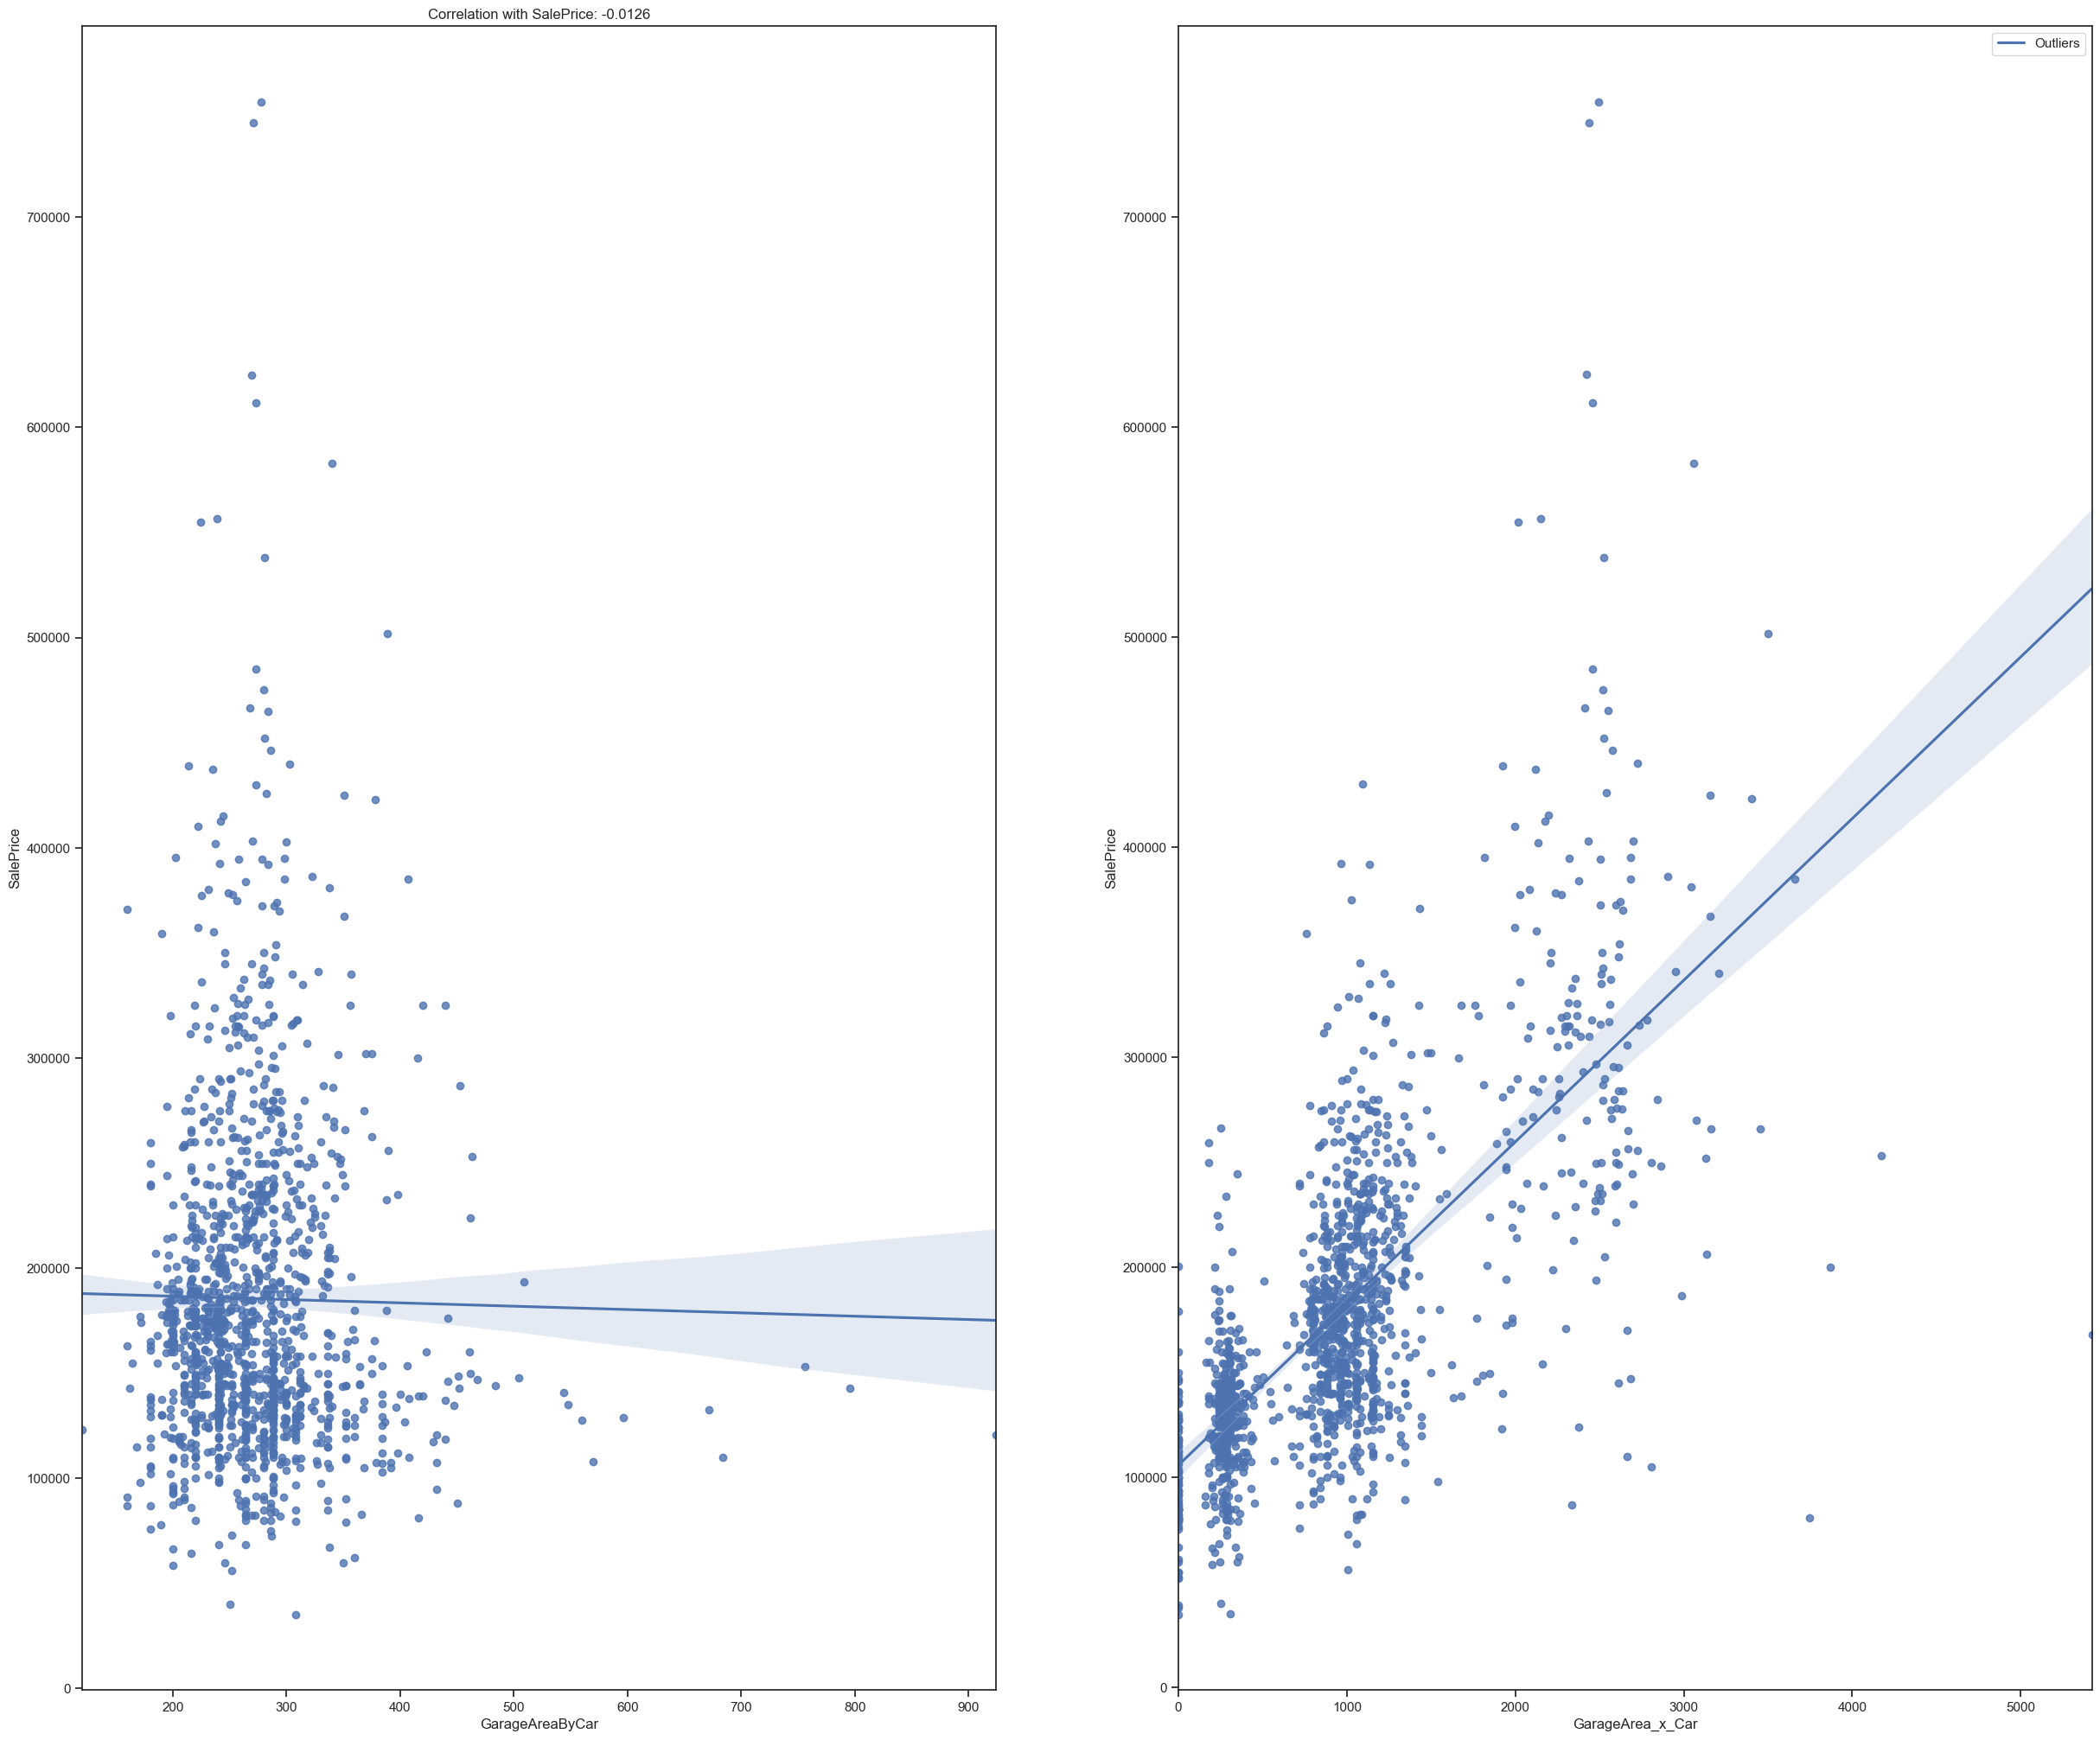

In [252]:
sns.reset_defaults()
sns.set(style="ticks", color_codes=True)
df = train[['SalePrice', 'GarageArea', 'GarageCars']]

df['GarageAreaByCar'] = train.GarageArea/train.GarageCars
df['GarageArea_x_Car'] = train.GarageArea*train.GarageCars


fig = plt.figure(figsize=(30,25))
fig1 = fig.add_subplot(121)
sns.regplot(x='GarageAreaByCar', y='SalePrice', data=df)
plt.title('Correlation with SalePrice: {:6.4f}'.format(df.GarageAreaByCar.corr(df['SalePrice'])))
fig2 = fig.add_subplot(122)
sns.regplot(x='GarageArea_x_Car', y='SalePrice', data=df)
plt.legend(['Outliers'])
df = df.loc[df.GarageArea_x_Car<3700]
plt.show()

In [253]:
df.GarageArea_x_Car.corr(df['SalePrice'])

0.7080885960396965

In [254]:
details.loc['GarageArea']

types                int64
counts                1460
distincts              441
nulls                    0
missing ration           0
skewness          0.179981
kurtosis          0.917067
corrSalePrice     0.623431
Name: GarageArea, dtype: object

In [255]:
details.loc['GarageCars']

types                int64
counts                1460
distincts                5
nulls                    0
missing ration           0
skewness         -0.342549
kurtosis          0.220998
corrSalePrice     0.640409
Name: GarageCars, dtype: object

We can see that with multiplication we achive to imprive corralation, and so we could drop  the two original metrics  and keep this, removing the outliers.

In [256]:
train = train[train.GarageArea * train.GarageCars < 3700]
print('Total observatiosn after outliers cut:', train.shape[0])

Total observatiosn after outliers cut: 1453


The variables for Total square feet of basement area and First Floor square feet are corralated a lot together. So maybe they can be combined to improve the regression! Let's check again the multiplication of them.

In [257]:
details.loc['TotalBsmtSF']

types                int64
counts                1460
distincts              721
nulls                    0
missing ration           0
skewness           1.52425
kurtosis           13.2505
corrSalePrice     0.613581
Name: TotalBsmtSF, dtype: object

In [258]:
details.loc['1stFlrSF']

types                int64
counts                1460
distincts              753
nulls                    0
missing ration           0
skewness           1.37676
kurtosis           5.74584
corrSalePrice     0.605852
Name: 1stFlrSF, dtype: object

In [259]:
details.loc['2ndFlrSF']

types                int64
counts                1460
distincts              417
nulls                    0
missing ration           0
skewness           0.81303
kurtosis         -0.553464
corrSalePrice     0.319334
Name: 2ndFlrSF, dtype: object

C:\Users\Christina\anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\Christina\anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


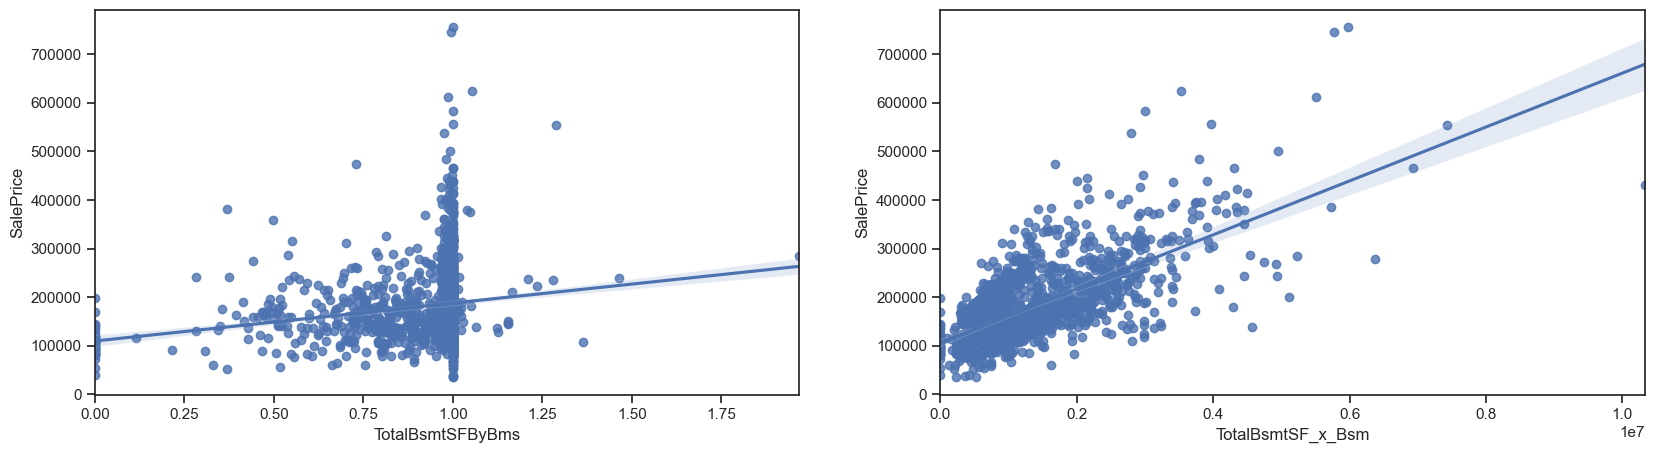

In [260]:
del df
df = train[['SalePrice', 'TotalBsmtSF', '1stFlrSF']]
df['TotalBsmtSFByBms'] = train.TotalBsmtSF/train['1stFlrSF']
df['TotalBsmtSF_x_Bsm'] = train.TotalBsmtSF*train['1stFlrSF']
fig = plt.figure(figsize=(20,5))
fig1 = fig.add_subplot(121); sns.regplot(x='TotalBsmtSFByBms', y='SalePrice', data=df);
fig2 = fig.add_subplot(122); sns.regplot(x='TotalBsmtSF_x_Bsm', y='SalePrice', data=df);
plt.show()

In [261]:
 df.TotalBsmtSFByBms.corr(df['SalePrice']) #too low

0.19862571357285702

In [263]:
 df.TotalBsmtSF_x_Bsm.corr(df['SalePrice']) #gooood.

0.6837745128715497

We improve corralation to SalePrice, so we can combine these variables by mutliplication and remove the two original. There are not so important outliers as it seems.

# Check dependent variable  - SalePrice

I will create a QQ-plot. A Q-Q plot, short for quantile-quantile plot, is often used to assess whether or not a set of data potentially came from some theoretical distribution. In most cases, this type of plot is used to determine whether or not a set of data follows a normal distribution.

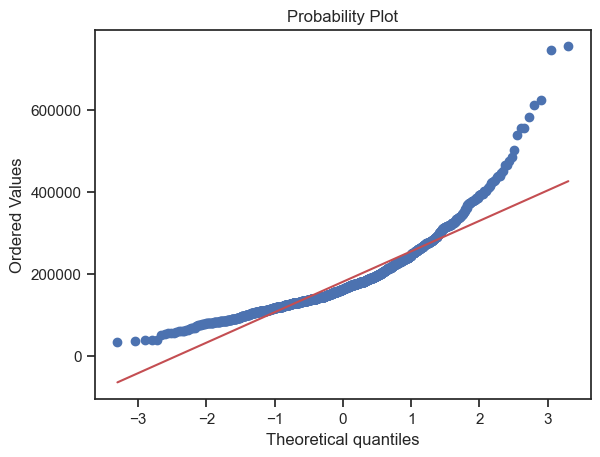

In [275]:
fig=stats.probplot(train['SalePrice'], plot=plt)
plt.show()

x-axis :theoretical quantiles means it doesn’t show our actual data, but instead it represents where our data would be if it were normally distributed.

The y-axis: displays our actual data. This means that if the data values fall along a roughly straight line at a 45-degree angle, then the data is normally distributed.
So we cen see that SalePrice does not align with the diagonal red line which represent normal distribution!Let's apply log(1+x) numpy function to all elements of the column and check the result

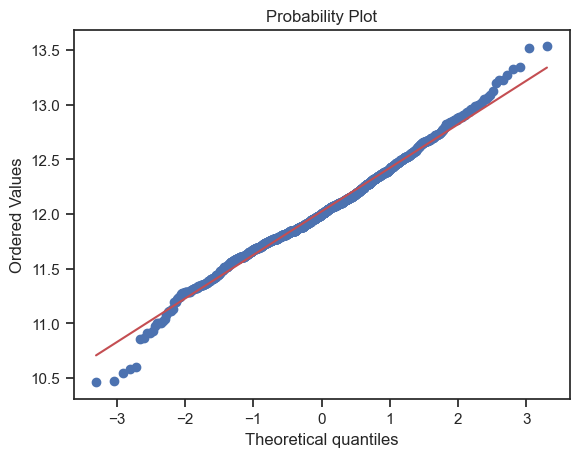

In [276]:
train.SalePrice = np.log1p(train.SalePrice)
fig=stats.probplot(train['SalePrice'], plot=plt)
plt.show()

We see that the the data are now more normally distributed.

In [278]:
train['SalePrice'].head()

0    12.247699
1    12.109016
2    12.317171
3    11.849405
4    12.429220
Name: SalePrice, dtype: float64

<AxesSubplot:xlabel='SalePrice', ylabel='Density'>

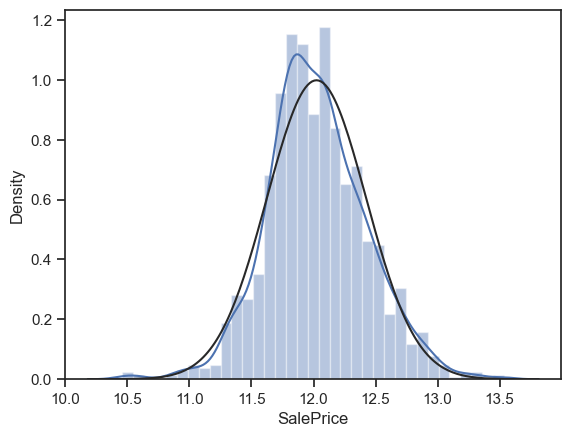

In [286]:
(mu, sigma) = norm.fit(train['SalePrice'])
sns.distplot(train['SalePrice'], fit=norm)

# Sum up of exploration.

1. We can drop the variables with the biggest missing ratio: MiscFeature, PoolQC, Alley,Fence
2. We can drop variables that are not so important for dataset, for example Utilities and Street. That's because all observations have the same value.

In [292]:
details.loc['Utilities']

types             object
counts              1460
distincts              2
nulls                  0
missing ration         0
skewness             NaN
kurtosis             NaN
corrSalePrice        NaN
Name: Utilities, dtype: object

In [293]:
train['Utilities'].value_counts() #we see that only 1 variable has Utilities NoSeWa

AllPub    1452
NoSeWa       1
Name: Utilities, dtype: int64

In [295]:
details.loc['Street']

types             object
counts              1460
distincts              2
nulls                  0
missing ration         0
skewness             NaN
kurtosis             NaN
corrSalePrice        NaN
Name: Street, dtype: object

In [296]:
train['Street'].value_counts() #we see that only 1 variable has Utilities NoSeWa

Pave    1448
Grvl       5
Name: Street, dtype: int64

In [297]:
train.shape

(1453, 81)

In [ ]:
train = train.drop(['Utilities', 'Street', 'PoolQC','MiscFeature', 'Alley','Fence'], axis=1)

In [306]:
train.shape

(1453, 75)

# Fill missing values

Check the categorical values for nulls:

In [307]:
categorical = train.select_dtypes(include=object).isna().sum().sort_values(ascending=False)
categorical[categorical > 0]

FireplaceQu     687
GarageCond       80
GarageQual       80
GarageFinish     80
GarageType       80
BsmtExposure     38
BsmtFinType2     38
BsmtQual         37
BsmtCond         37
BsmtFinType1     37
MasVnrType        8
Electrical        1
dtype: int64

In [314]:
cat_variables=['FireplaceQu','GarageCond','GarageQual','GarageFinish','GarageType','BsmtExposure',
               'BsmtFinType2','BsmtQual','BsmtCond',
               'BsmtFinType1','MasVnrType','Electrical']

In [309]:
#let's replace NaN
train['FireplaceQu'] = train['FireplaceQu'].fillna('None')
train['GarageCond'] = train['GarageCond'].fillna('None')
train['GarageQual'] = train['GarageQual'].fillna('None')
train['GarageFinish'] = train['GarageFinish'].fillna('None')
train['GarageType'] = train['GarageType'].fillna('None')
train['BsmtExposure'] = train['BsmtExposure'].fillna('None')
train['BsmtFinType2'] = train['BsmtFinType2'].fillna('None')
train['BsmtQual'] = train['BsmtQual'].fillna('None')
train['BsmtCond'] = train['BsmtCond'].fillna('None')
train['BsmtFinType1'] = train['BsmtFinType1'].fillna('None')
train['MasVnrType'] = train['MasVnrType'].fillna('None')
train['Electrical'] = train['Electrical'].fillna('None')

In [312]:
#check
categorical = train.select_dtypes(include=object).isna().sum().sort_values(ascending=False)
categorical[categorical > 0]

Series([], dtype: int64)

In [315]:
train[cat_variables].isnull().sum()

FireplaceQu     0
GarageCond      0
GarageQual      0
GarageFinish    0
GarageType      0
BsmtExposure    0
BsmtFinType2    0
BsmtQual        0
BsmtCond        0
BsmtFinType1    0
MasVnrType      0
Electrical      0
dtype: int64

Check the numerical variables for missing:

In [317]:
num = train.select_dtypes(include=np.number).isna().sum().sort_values(ascending=False)
num[num > 0]

LotFrontage    258
GarageYrBlt     80
MasVnrArea       8
dtype: int64

In [319]:
train['LotFrontage'] = train.groupby("Neighborhood")["LotFrontage"].transform(lambda x: x.fillna(x.median()))
train['GarageYrBlt'] = train['GarageYrBlt'].fillna(int(0))
train['MasVnrArea'] = train['MasVnrArea'].fillna(int(0))

In [320]:
num_variables=['LotFrontage','GarageYrBlt','MasVnrArea']
train[num_variables].isnull().sum()

LotFrontage    0
GarageYrBlt    0
MasVnrArea     0
dtype: int64

In [322]:
train.isnull().sum().sum()

0

In [326]:
train.shape

(1453, 75)

# One hot encoding for categorical values

In [329]:
def one_hot_encode(df):
    categorical_cols = df.select_dtypes(include=['object']).columns

    print(len(categorical_cols), "categorical columns")
    print(categorical_cols)
    # Remove special charactres and withe spaces. 
    for col in categorical_cols:
        df[col] = df[col].str.replace('\W', '').str.replace(' ', '_') #.str.lower()

    dummies = pd.get_dummies(df[categorical_cols], columns = categorical_cols).columns
    df = pd.get_dummies(df, columns = categorical_cols)

    print("Total Columns:",len(df.columns))
    print(df.info())
    
    return df, dummies

# Correct Categorical from int to str types
train.MSSubClass = train.MSSubClass.astype('str')
train.MoSold = train.MoSold.astype('str')

train, dummies = one_hot_encode(train)

39 categorical columns
Index(['MSSubClass', 'MSZoning', 'LotShape', 'LandContour', 'LotConfig',
       'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType',
       'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd',
       'MasVnrType', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual',
       'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'Heating',
       'HeatingQC', 'CentralAir', 'Electrical', 'KitchenQual', 'Functional',
       'FireplaceQu', 'GarageType', 'GarageFinish', 'GarageQual', 'GarageCond',
       'PavedDrive', 'MoSold', 'SaleType', 'SaleCondition'],
      dtype='object')
Total Columns: 308
<class 'pandas.core.frame.DataFrame'>
Int64Index: 1453 entries, 0 to 1459
Columns: 308 entries, Id to SaleCondition_Partial
dtypes: float64(4), int64(32), uint8(272)
memory usage: 806.0 KB
None


In [330]:
train.shape

(1453, 308)

In [331]:
train.head()

,Id,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,...,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_Abnorml,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
0,1,65.0,8450,7,5,2003,2003,196.0,706,0,...,0,0,0,1,0,0,0,0,1,0
1,2,80.0,9600,6,8,1976,1976,0.0,978,0,...,0,0,0,1,0,0,0,0,1,0
2,3,68.0,11250,7,5,2001,2002,162.0,486,0,...,0,0,0,1,0,0,0,0,1,0
3,4,60.0,9550,7,5,1915,1970,0.0,216,0,...,0,0,0,1,1,0,0,0,0,0
4,5,84.0,14260,8,5,2000,2000,350.0,655,0,...,0,0,0,1,0,0,0,0,1,0


Also,let's Drop the features with highest correlations to other Features. I found above that:
1. GarageCars and GarageArea is very high (0.88), and has very close correlation with the SalePrice.
2. Total square feet of basement area (TotalBsmtSF) and first Floor square feet (1stFlrSF), we found 0.81 of correlation and same correlation with sale price (0.61).

In [333]:
train.drop(['TotalBsmtSF', 'GarageArea', 'GarageCars', '1stFlrSF'], axis=1, inplace=True)

In [334]:
train.shape

(1453, 304)

In [345]:
train['SalePrice']

0       12.247699
1       12.109016
2       12.317171
3       11.849405
4       12.429220
          ...    
1455    12.072547
1456    12.254868
1457    12.493133
1458    11.864469
1459    11.901590
Name: SalePrice, Length: 1453, dtype: float64

# MODELING - REGRESSION

In [644]:
tr=train[train.columns.drop('SalePrice')]
x= pd.DataFrame(tr)
y = pd.DataFrame(train['SalePrice'])

In [645]:
X_train, X_test, y_train, y_test = train_test_split(x, y,  test_size=0.20, random_state=1)

In [646]:
print(X_train.shape , X_test.shape, y_train.shape, y_test.shape)

(1162, 303) (291, 303) (1162, 1) (291, 1)


# Linear Regression

In [647]:
# LINEAR REGRESSION
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import KFold, cross_val_score, train_test_split

lr = LinearRegression()
scores = cross_val_score(lr, X_train, y_train, scoring='r2', cv=10)
scores

array([0.9278276 , 0.90644165, 0.89320874, 0.92095319, 0.85964111,
       0.92403588, 0.91868124, 0.89037245, 0.88678097, 0.86802174])

In [648]:
scores.mean()

0.8995964562270551

In [649]:
lr.fit(X_train, y_train)               

LinearRegression()

In [650]:
print("Accuracy --> ", round(lr.score(X_test, y_test)*100),"%")

Accuracy -->  87 %


In [651]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
predictions_1 = lr.predict(X_test)
print('RMSE is: \n', mean_squared_error(y_test, predictions_1))

RMSE is: 
 0.02085134760651887


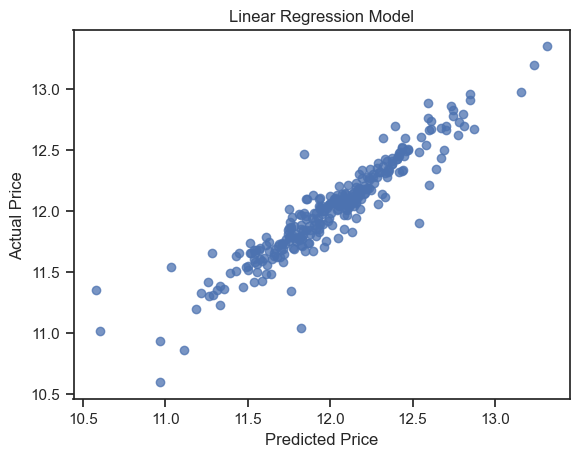

In [652]:
actual_values = y_test
plt.scatter(predictions_1, actual_values, alpha=.75,
            color='b')  # alpha helps to show overlapping data
plt.xlabel('Predicted Price')
plt.ylabel('Actual Price')
plt.title('Linear Regression Model')
plt.show()

In [654]:
r2 = sklearn.metrics.r2_score(y_test, predictions_1 )
r2

0.8672176649500853

The accuracy of Linear Regression model is 0.8672176649500853

# Lasso Regression

In [655]:
model=Lasso(alpha=0.1)
model.fit(X_train, y_train)
print("Accuracy --> ", round(model.score(X_test, y_test)*100),"%")

Accuracy -->  81 %


In [656]:
from sklearn.linear_model import Lasso

alpha=[0.00001,0.01,0.001,0.002,0.0001, 0.02, 0.03, 0.05, 1.0,0.5]
k_scores= []
for a in alpha:
    model = Lasso(a)
    scores= cross_val_score(model, X_train, y_train, scoring='r2', cv=10)
    k_scores.append(scores.mean())

C:\Users\Christina\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3.598160812123459, tolerance: 0.01602202892039452
  positive)
C:\Users\Christina\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3.674471975825923, tolerance: 0.016944855189806513
  positive)
C:\Users\Christina\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3.5579720072910774, tolerance: 0.01684399865615785
  positive)
C:\Users\Christina\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number 

In [657]:
k_scores

[0.9036534981295372,
 0.8854625078133689,
 0.9183112446739929,
 0.9110777671139809,
 0.9163328836085618,
 0.8800944084700462,
 0.8720966588006179,
 0.8511839939309155,
 0.8209236828098003,
 0.8360883565734613]

Text(0, 0.5, 'Cross-Validated Accuracy')

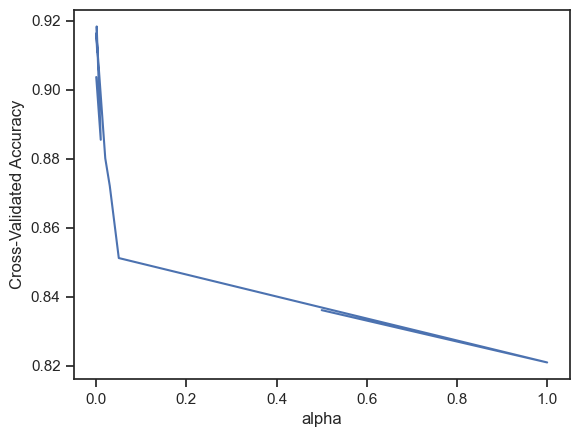

In [658]:
plt.plot(alpha, k_scores)
plt.xlabel('alpha')
plt.ylabel('Cross-Validated Accuracy')

So we keep as alpha value 0.001 which have the biggest score. 

In [438]:
lassofinal = Lasso(alpha=0.001)
lassofinal.fit(X_train,y_train)
y_predfinal_lasso = lassofinal.predict(X_test)
print('Lassofinalscore:')
print('RMSE is: \n', mean_squared_error(y_test, y_predfinal_lasso))

Lassofinalscore:
RMSE is: 
 0.01628879505300883


In [439]:
r3 = sklearn.metrics.r2_score(y_test, y_predfinal_lasso )
r3

0.8962722082474984

# Gaussian Process - Linear Kernel

In Gaussian process regression a kernel function (or covariance function) is used to help to mould the shape of prior and posterior values.

In [670]:
#linear kernel for choosing kernel simple DotProduct and sigma value 0.
import sklearn.gaussian_process as gp
model = gp.GaussianProcessRegressor(kernel=DotProduct(sigma_0=0), n_restarts_optimizer=10, alpha=0.1, normalize_y=True)
model.fit(X_train, y_train)
params = model.kernel_.get_params()

C:\Users\Christina\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:255: RuntimeWarning: divide by zero encountered in log
  return np.log(np.hstack(theta))
C:\Users\Christina\anaconda3\lib\site-packages\sklearn\gaussian_process\_gpr.py:504: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


In [671]:
y_pred, std = model.predict(X_test, return_std=True)

C:\Users\Christina\anaconda3\lib\site-packages\sklearn\gaussian_process\_gpr.py:370: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "


In [672]:
print('RMSE is: \n', mean_squared_error(y_test, y_pred))

RMSE is: 
 0.02022402960196016


In [673]:
r4 = sklearn.metrics.r2_score(y_test, y_pred)
r4

0.8712124546891484

The accuracy is 0.8712142233603082 with linear kernel

# Gaussian Process Regression - Gaussian Kernel

The exponentiated quadratic kernel (also known as squared exponential kernel, Gaussian kernel or radial basis function kernel) is one of the most popular kernels used in Gaussian process modelling. It can be computed as:
1. K(x,y) = exp(- (norm(x-y))^2 / 2*l^2) 

In [503]:
kernel=gp.kernels.RBF(length_scale=1,  length_scale_bounds=(1e-05, 100000.0))


model_rbf = gp.GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=10, alpha=0.1, normalize_y=True)

scores = cross_val_score(model_rbf, X_train, y_train, scoring='r2', cv=10)

scores

array([0.79263046, 0.73919708, 0.76008794, 0.70713329, 0.71919345,
       0.7753973 , 0.76034712, 0.79681922, 0.67299278, 0.76143803])

In [504]:
scores.mean()

0.7485236665987927

In [505]:
model_rbf.fit(X_train, y_train)               

GaussianProcessRegressor(alpha=0.1, kernel=RBF(length_scale=1),
                         n_restarts_optimizer=10, normalize_y=True)

In [506]:
pred_rbf = model_rbf.predict(X_test)
print('RMSE is: \n', mean_squared_error(y_test, pred_rbf))

RMSE is: 
 0.04546127907494338


In [507]:
r5 = sklearn.metrics.r2_score(y_test, y_pred_rbf)
r5

0.7105004959935763

# MLP 1 hidden layer

In [539]:
scaler = MinMaxScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)
 
scaler.fit(X_test)
X_test = scaler.transform(X_test)

In [563]:
from sklearn.neural_network import MLPRegressor

model_mlp_1 = MLPRegressor(hidden_layer_sizes=300, activation='relu', solver='adam', alpha=0.0001, 
                           batch_size='auto', learning_rate='constant', learning_rate_init=0.001, 
                           power_t=0.5, max_iter=200, shuffle=True, random_state=None, tol=0.0001, 
                           verbose=False, warm_start=False, momentum=0.9, nesterovs_momentum=True, 
                           early_stopping=False, validation_fraction=0.1, beta_1=0.9, beta_2=0.999, 
                           epsilon=1e-08, n_iter_no_change=10, max_fun=15000)

scores = cross_val_score(model_mlp_1, X_train, y_train, scoring='r2', cv=10)

scores


C:\Users\Christina\anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\Users\Christina\anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\Users\Christina\anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\Users\Christina\anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel(

array([0.9048899 , 0.88085822, 0.79397184, 0.82755101, 0.86160967,
       0.89327113, 0.88215292, 0.85339672, 0.78412066, 0.79765237])

In [564]:
scores.mean()

0.8479474446963

In [565]:
model_mlp_1.fit(X_train, y_train)

C:\Users\Christina\anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


MLPRegressor(hidden_layer_sizes=300)

In [566]:
y_pred_mlp_1=model_mlp_1.predict(X_test)
print('RMSE is: \n', mean_squared_error(y_test, y_pred_mlp_1))

RMSE is: 
 0.048646853334542196


In [567]:
r6 = sklearn.metrics.r2_score(y_test, y_pred_mlp_1)
r6

0.690214613439575

The r2 accuracy of MLP with 1 hidden layer is 0.686724999041809

# MLP 2 hidden leayers

Let's choose the number of neurons in hidden layer by the mean of the neurons in the input and output layers. So for the first layer 300 neurons and the other one 200. ( We have 304 features)

In [557]:
model_mlp_2 = MLPRegressor(hidden_layer_sizes=(300,200), activation='relu', solver='adam', alpha=0.0001, 
                           batch_size='auto', learning_rate='constant', learning_rate_init=0.001, 
                           power_t=0.5, max_iter=200, shuffle=True, random_state=None, tol=0.0001, 
                           verbose=False, warm_start=False, momentum=0.9, nesterovs_momentum=True, 
                           early_stopping=False, validation_fraction=0.1, beta_1=0.9, beta_2=0.999, 
                           epsilon=1e-08, n_iter_no_change=10, max_fun=15000)

scores = cross_val_score(model_mlp_2, X_train, y_train, scoring='r2', cv=10)

scores
#model_mlp_1.fit(X_train, y_train)

C:\Users\Christina\anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\Users\Christina\anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\Users\Christina\anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\Users\Christina\anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel(

array([0.86081442, 0.86342103, 0.82228467, 0.8768407 , 0.83484969,
       0.86151741, 0.89154111, 0.82265247, 0.76904267, 0.78959972])

In [558]:
scores.mean() #score in train set

0.8392563896077307

In [559]:
model_mlp_2.fit(X_train, y_train)

C:\Users\Christina\anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


MLPRegressor(hidden_layer_sizes=(300, 200))

In [560]:
y_pred_mlp_2=model_mlp_2.predict(X_test)
print('RMSE is: \n', mean_squared_error(y_test, y_pred_mlp_2))

RMSE is: 
 0.02981312647939389


In [561]:
r7 = sklearn.metrics.r2_score(y_test, y_pred_mlp_2)
r7

0.8101486472828862

# Polynomial Regression for 2 degrees

 run again the commands for X_train, y_train, X_test, y_test split, to use StandardScaler()

In [631]:
sc=StandardScaler()
X_train_sc= sc.fit_transform(X_train)
X_test_sc= sc.fit_transform(X_test)

poly_features = PolynomialFeatures(degree = 2, include_bias=False)  
X_train_poly = poly_features.fit_transform(X_train_sc)
lrg = LinearRegression()
scores = cross_val_score(lrg, X_train, y_train, scoring='r2', cv=10)
scores

array([0.9278276 , 0.90644165, 0.89320874, 0.92095319, 0.85964111,
       0.92403588, 0.91868124, 0.89037245, 0.88678097, 0.86802174])

In [632]:
scores.mean() # in accuracy set

0.8995964562270551

In [633]:
lrg.fit(X_train_poly, y_train)

LinearRegression()

In [634]:
X_test_sc.shape

(291, 303)

In [635]:
X_test_poly = poly_features.fit_transform(X_test_sc)

In [636]:
X_test_poly.shape

(291, 46359)

In [637]:
y_pred_poly= lrg.predict(X_test_poly)

In [638]:
print('RMSE is: \n', mean_squared_error(y_test, y_pred_poly))

RMSE is: 
 0.03768185837826222


In [639]:
r8 = sklearn.metrics.r2_score(y_test, y_pred_poly)
r8

0.7600402027290754

# METHODS COMPARISON 

In [681]:
RMSE_scores = []

from sklearn.metrics import mean_squared_error as rmse

linear_model_rmse = rmse(y_test, predictions_1)
RMSE_scores.append(linear_model_rmse)

lasso_model_rmse = rmse(y_test, y_predfinal_lasso)
RMSE_scores.append(lasso_model_rmse)

gaussprocess_linear_model_rmse = rmse(y_test, y_pred)
RMSE_scores.append(gaussprocess_linear_model_rmse)

gaussianprocess_rbf_model_rmse = rmse(y_test, y_pred_rbf)
RMSE_scores.append(gaussianprocess_rbf_model_rmse)

mlp1_model_rmse = rmse(y_test, y_pred_mlp_1)
RMSE_scores.append(mlp1_model_rmse)

mlp2_model_rmse = rmse(y_test, y_pred_mlp_2)
RMSE_scores.append(mlp2_model_rmse)

poly_model_rmse = rmse(y_test, y_pred_poly)
RMSE_scores.append(poly_model_rmse)

In [688]:
All_models = ['Linear','Lasso','GP_Linear',
              'GP_rbf','Mlp1layer','Mlp2layers','Polynomial']

final_scores = pd.DataFrame(All_models, columns = ['Regressors'])
final_scores['RMSE_scores'] = RMSE_scores

In [689]:
final_scores

,Regressors,RMSE_scores
0,Linear,0.020851
1,Lasso,0.016289
2,GP_Linear,0.020224
3,GP_rbf,0.045461
4,Mlp1layer,0.048647
5,Mlp2layers,0.029813
6,Polynomial,0.037682


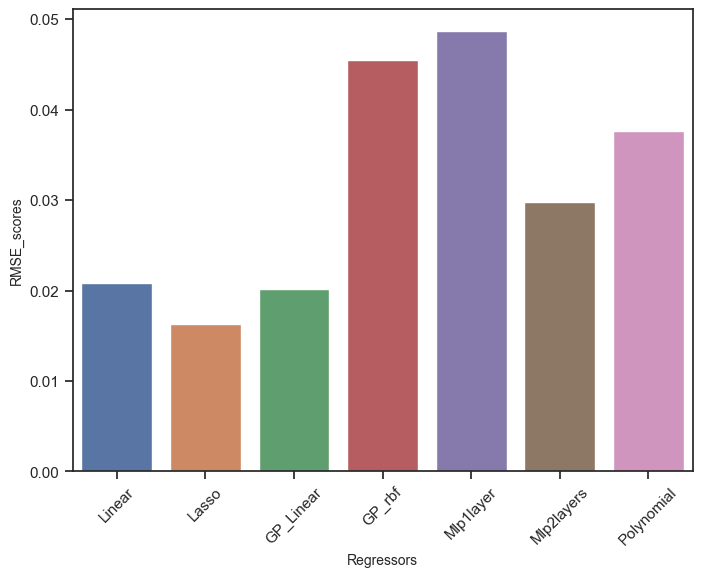

In [690]:
plt.figure(figsize = (8,6))
sns.barplot(final_scores['Regressors'],final_scores['RMSE_scores'])
plt.xlabel('Regressors', fontsize = 10)
plt.ylabel('RMSE_scores', fontsize = 10)
plt.xticks(rotation=45)
plt.show()